In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import shutil

In [2]:
bpath = r'D:\Downloads\kaggle datas\pneumonia_chest_xray\bacteria'
vpath = r'D:\Downloads\kaggle datas\pneumonia_chest_xray\virus'
npath = r'D:\Downloads\kaggle datas\pneumonia_chest_xray\normal'

org_dir = r'D:\Downloads\kaggle datas\pneumonia_chest_xray'
base_dir = r'D:\Downloads\kaggle datas\XrayReports'

trainPath = os.path.sep.join([base_dir,'train'])
testPath = os.path.sep.join([base_dir,'test'])
valPath = os.path.sep.join([base_dir,'val'])

trainSplit = 0.8
valSplit = 0.1

In [3]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [4]:
bimgPath = list(paths.list_images(bpath))
vimgPath = list(paths.list_images(vpath))
nimgPath = list(paths.list_images(npath))

In [5]:
i = int(len(bimgPath)*trainSplit)
j = int(len(vimgPath)*trainSplit)
k = int(len(nimgPath)*trainSplit)
l = int(len(bimgPath)*valSplit)
m = int(len(vimgPath)*valSplit)
n = int(len(nimgPath)*valSplit)

In [6]:
btrain = bimgPath[:i]
vtrain = vimgPath[:j]
ntrain = nimgPath[:k]

btest = bimgPath[i:]
vtest = vimgPath[j:]
ntest = nimgPath[k:]

bval = btrain[:l]
btrain = btrain[l:]
vval = vtrain[:m]
vtrain = vtrain[m:]
nval = ntrain[:n]
ntrain = ntrain[n:]


In [7]:
train = btrain+vtrain+ntrain
test = btest+vtest+ntest
val = bval+vval+nval

In [8]:
random.seed(42)
random.shuffle(train)
random.shuffle(test)
random.shuffle(val)

In [9]:
dataset = [("training",train,trainPath),
          ("testing",test,testPath),
          ("validation",val,valPath)]

In [10]:
for (dtype,imgpaths,baseoutputs) in dataset:
    if not os.path.exists(baseoutputs):
        os.makedirs(baseoutputs)
    for path in imgpaths:
        filename = path.split(os.path.sep)[-1]
        label = path.split(os.path.sep)[-1].split('_')[0]
        labelPath = os.path.sep.join([baseoutputs,label])
        if not os.path.exists(labelPath):
            os.makedirs(labelPath)
        p = os.path.sep.join([labelPath,filename])
        shutil.copy2(path,p)

#### Image Preprocessing, Label and Data Generation 

In [4]:
imagePaths = list(paths.list_images(trainPath))
train_data = []
train_labels = []

for img in imagePaths:
    label = img.split(os.path.sep)[-2]
    image = cv2.imread(img)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(224,224))
    train_data.append(image)
    train_labels.append(label)
train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

In [5]:
imagePaths = list(paths.list_images(testPath))
test_data = []
test_labels = []

for img in imagePaths:
    label = img.split(os.path.sep)[-2]
    image = cv2.imread(img)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(224,224))
    test_data.append(image)
    test_labels.append(label)
test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

In [6]:
imagePaths = list(paths.list_images(valPath))
val_data = []
val_labels = []

for img in imagePaths:
    label = img.split(os.path.sep)[-2]
    image = cv2.imread(img)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(224,224))
    val_data.append(image)
    val_labels.append(label)
val_data = np.array(val_data)/255.0
val_labels = np.array(val_labels)

In [7]:
print(train_data.shape,test_data.shape,val_data.shape)

(3138, 224, 224, 3) (897, 224, 224, 3) (448, 224, 224, 3)


In [8]:
train_labels.shape,test_labels.shape,val_labels.shape

((3138,), (897,), (448,))

In [9]:
le = LabelEncoder()

In [10]:
train_labels = to_categorical(le.fit_transform(train_labels))
test_labels = to_categorical(le.transform(test_labels))
val_labels = to_categorical(le.transform(val_labels))

print(train_labels.shape,test_labels.shape,val_labels.shape)

(3138, 3) (897, 3) (448, 3)


[0]


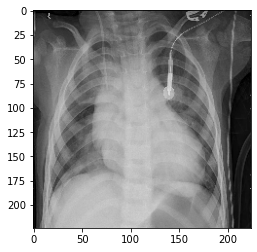

In [11]:
plt.imshow(train_data[0])
print([np.argmax(train_labels[0],axis=-1)])

#### Model building and training

In [13]:
model = load_model('pnuemonia_classifier.h5')

In [19]:
conv_basic = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
conv_basic.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
headModel = conv_basic.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)


In [21]:
model = Model(inputs=conv_basic.input, outputs=headModel)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [22]:
for layer in conv_basic.layers:
    layer.trainable = False

In [23]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [18]:
train_aug = ImageDataGenerator(rotation_range=15,fill_mode='nearest')

In [ ]:
history = model.fit(train_aug.flow(train_data,train_labels,batch_size=BS),steps_per_epoch=len(train_data)//BS,
                   validation_data=(val_data,val_labels),validation_steps=len(val_data)//BS,
                   epochs=EPOCHS)
model_path = 'pnuemonia.h5'
model.save(model_path,save_format='h5')

Epoch 1/25
392/392 [==============================] - 395s 1s/step - loss: 0.8910 - accuracy: 0.5748 - val_loss: 0.7288 - val_accuracy: 0.6518
Epoch 2/25
392/392 [==============================] - 394s 1s/step - loss: 0.7150 - accuracy: 0.6859 - val_loss: 0.6737 - val_accuracy: 0.6987
Epoch 3/25
392/392 [==============================] - 389s 994ms/step - loss: 0.6432 - accuracy: 0.7185 - val_loss: 0.6657 - val_accuracy: 0.7143
Epoch 4/25
392/392 [==============================] - 397s 1s/step - loss: 0.6066 - accuracy: 0.7527 - val_loss: 0.6423 - val_accuracy: 0.7232
Epoch 5/25
392/392 [==============================] - 394s 1s/step - loss: 0.5710 - accuracy: 0.7716 - val_loss: 0.6567 - val_accuracy: 0.7188
Epoch 6/25
392/392 [==============================] - 401s 1s/step - loss: 0.5636 - accuracy: 0.7719 - val_loss: 0.6363 - val_accuracy: 0.7344
Epoch 7/25
392/392 [==============================] - 400s 1s/step - loss: 0.5632 - accuracy: 0.7716 - val_loss: 0.6341 - val_accuracy: 0.7

In [14]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

#### Fine tuning the model : Unfreezing few layers to increase model performance 

In [15]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
conv_basic.trainable = True

set_trainable = False
for layer in conv_basic.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [16]:
LR = 1e-5
opt = Adam(learning_rate=LR,decay=LR/EPOCHS)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
history = model.fit(train_aug.flow(train_data,train_labels,batch_size=BS),steps_per_epoch=len(train_data)//BS,
                   validation_data=(val_data,val_labels),validation_steps=len(val_data)//BS,
                   epochs=EPOCHS)
model_path = 'finetuned_pnuemonia.h5'
model.save(model_path,save_format='h5')

Epoch 1/25
392/392 [==============================] - 520s 1s/step - loss: 0.5711 - accuracy: 0.7412 - val_loss: 0.5532 - val_accuracy: 0.8013
Epoch 2/25
392/392 [==============================] - 515s 1s/step - loss: 0.5351 - accuracy: 0.7585 - val_loss: 0.4014 - val_accuracy: 0.8326
Epoch 3/25
392/392 [==============================] - 510s 1s/step - loss: 0.5109 - accuracy: 0.7760 - val_loss: 0.4308 - val_accuracy: 0.8326
Epoch 4/25
392/392 [==============================] - 506s 1s/step - loss: 0.4945 - accuracy: 0.7789 - val_loss: 0.4286 - val_accuracy: 0.8170
Epoch 5/25
392/392 [==============================] - 500s 1s/step - loss: 0.4513 - accuracy: 0.8019 - val_loss: 0.5359 - val_accuracy: 0.7991
Epoch 6/25
392/392 [==============================] - 480s 1s/step - loss: 0.4665 - accuracy: 0.7955 - val_loss: 0.4369 - val_accuracy: 0.8259
Epoch 7/25
392/392 [==============================] - 480s 1s/step - loss: 0.4305 - accuracy: 0.8185 - val_loss: 0.4090 - val_accuracy: 0.8304

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
plt.style.use('dark_background')

In [31]:
preds = model.predict(test_data,steps=len(test_data)//BS)
preds = np.argmax(preds,axis=1)
print(classification_report(np.argmax(test_labels,axis=1),preds,target_names=le.classes_))

              precision    recall  f1-score   support

    bacteria       0.81      0.85      0.83       298
      normal       0.92      1.00      0.96       300
       virus       0.87      0.76      0.81       299

    accuracy                           0.87       897
   macro avg       0.87      0.87      0.86       897
weighted avg       0.87      0.87      0.87       897



[[253  12  33]
 [  1 299   0]
 [ 59  14 226]]
acc: 0.6154
sensitivity: 0.9547
specificity: 0.9967


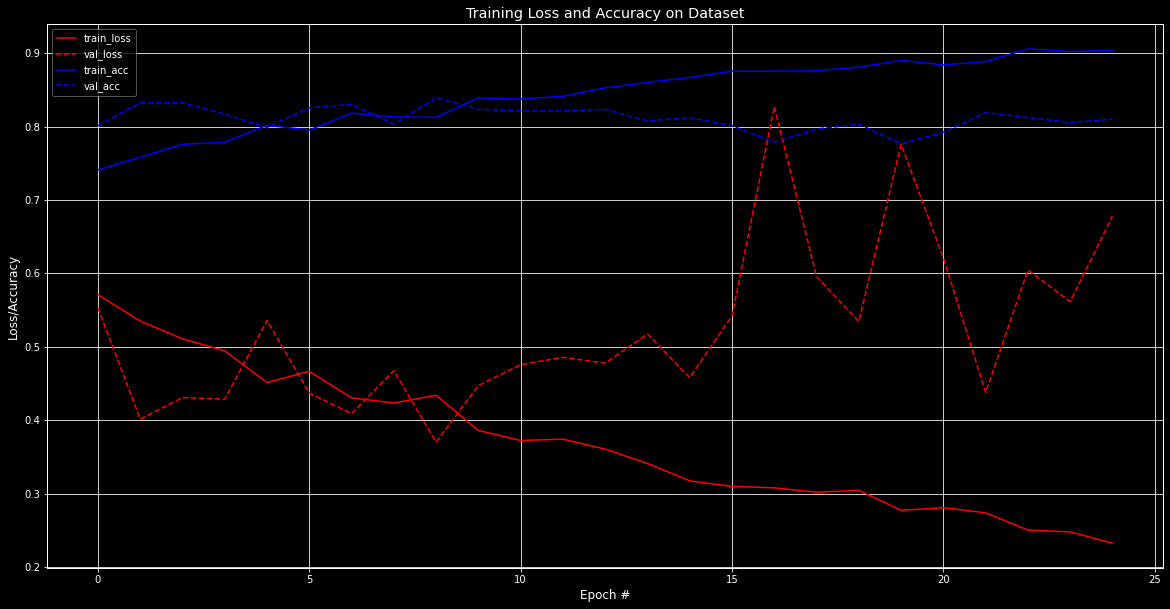

In [47]:
cm = confusion_matrix(np.argmax(test_labels,axis=1), preds)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

N = EPOCHS
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), history.history["loss"],'-r', label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"],'--r', label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"],'-b', label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"],'--b', label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

plt.show()

In [82]:
test_image = r'D:\Downloads\kaggle datas\pneumonia\chest_xray\chest_xray\train\NORMAL\IM-0133-0001.jpeg'

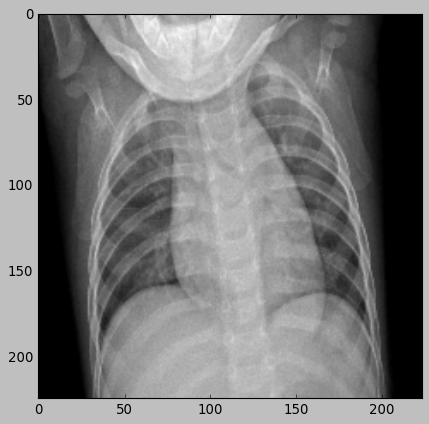

In [83]:
image = cv2.imread(test_image)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(224,224))
image = np.array(image)/255.0
sample = np.expand_dims(image,axis=0)
plt.style.use('classic')
plt.imshow(image)

In [84]:
sample.shape

(1, 224, 224, 3)

In [85]:
le.classes_[np.argmax(model.predict(sample))]

'normal'

#### Note: Feel free to alter the Learning Rate, and Add a DropOut layer after final MaxPooling layer and experiment further to increase the model performance